# 🩺 Disease Prediction Model
### Machine Learning for Healthcare Diagnostics

**Author:** Bernadette Burks  
**Date:** September 14, 2025  

---

## 1. Project Overview

This notebook explores a supervised machine learning approach for predicting disease outcomes based on symptom data.

Goals include:

- Training multiple classifiers  
- Evaluating performance with cross-validation  
- Comparing results using confusion matrices  

---

## 2. Import Libraries

In [30]:
import numpy as np
import pandas as pd
from statistics import mode
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler


---

## 3. Load Dataset

In [31]:
data = pd.read_csv(r'C:\improved_disease_dataset.csv')
print(f"Dataset rows: {len(data)}")

Dataset rows: 2000



---

## 4. Data Preprocessing

- Encode labels  
- Check for imbalance  
- Apply oversampling if needed

In [32]:
encoder = LabelEncoder()
data["disease"] = encoder.fit_transform(data["disease"])

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

### Visualize Class Distribution

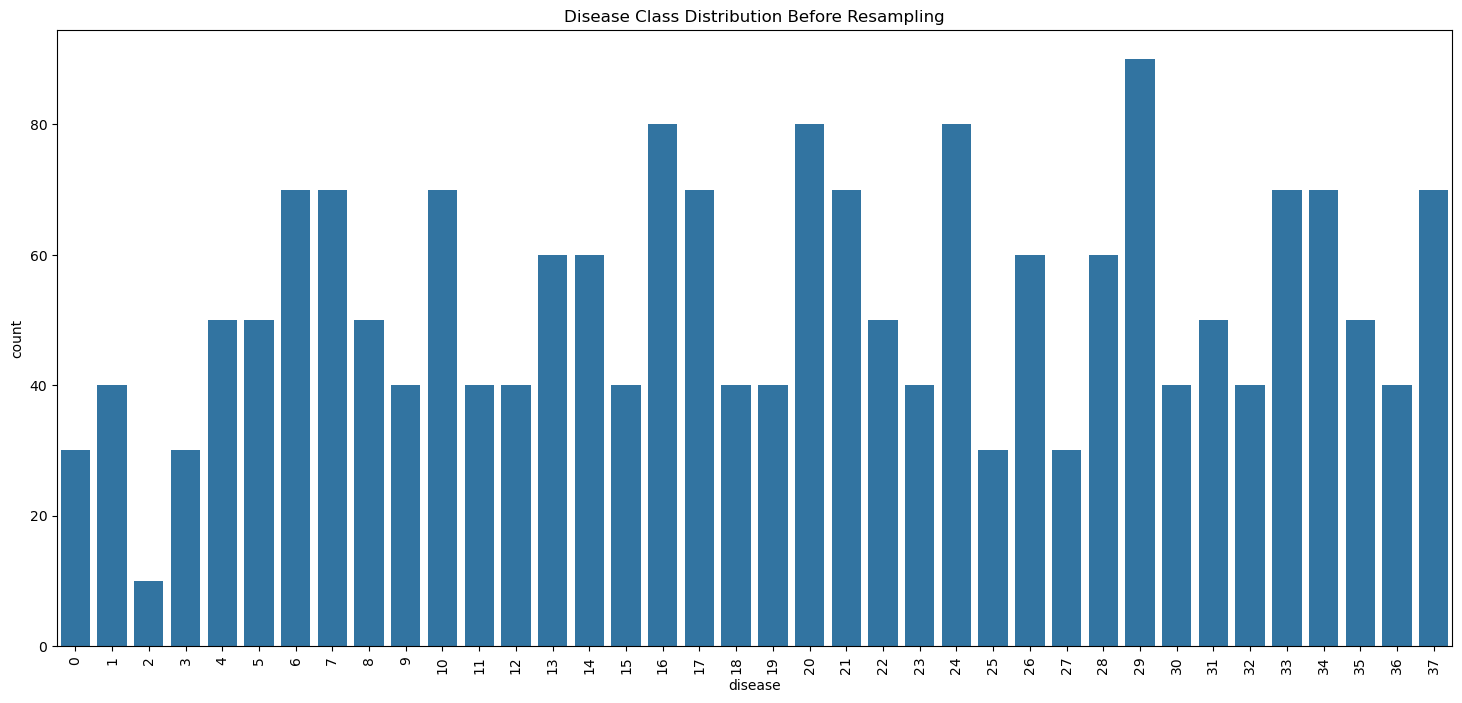

In [33]:
plt.figure(figsize=(18, 8))
sns.countplot(x=y)
plt.title("Disease Class Distribution Before Resampling")
plt.xticks(rotation=90)
plt.show()

### Oversample Dataset

In [34]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Optional: encode gender if exists
if 'gender' in X_resampled.columns:
    le = LabelEncoder()
    X_resampled['gender'] = le.fit_transform(X_resampled['gender'])

X_resampled = X_resampled.fillna(0)
if len(y_resampled.shape) > 1:
    y_resampled = y_resampled.values.ravel()


---

## 5. Model Training & Cross-Validation

In [35]:
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

cv_scoring = 'accuracy'
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    try:
        scores = cross_val_score(
            model,
            X_resampled,
            y_resampled,
            cv=stratified_kfold,
            scoring=cv_scoring,
            n_jobs=-1,
            error_score='raise' 
        )
        print("=" * 50)
        print(f"Model: {model_name}")
        print(f"Scores: {scores}")
        print(f"Mean Accuracy: {scores.mean():.4f}")
    except Exception as e:
        print("=" * 50)
        print(f"Model: {model_name} failed with error:")
        print(e)

Model: Decision Tree
Scores: [0.5497076  0.54532164 0.53216374 0.53654971 0.52631579]
Mean Accuracy: 0.5380
Model: Random Forest
Scores: [0.54385965 0.54093567 0.54678363 0.53070175 0.54093567]
Mean Accuracy: 0.5406
Model: SVM
Scores: [0.51315789 0.51169591 0.49707602 0.48245614 0.49561404]
Mean Accuracy: 0.5000


### Train & Evaluate Individual Models

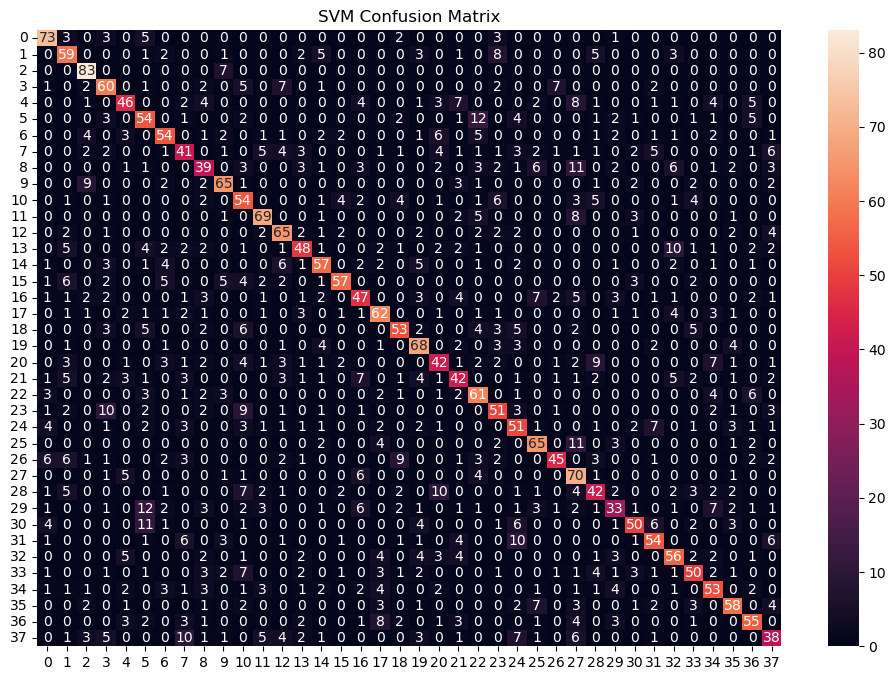

SVM Confusion Matrix Accuracy: 60.53%


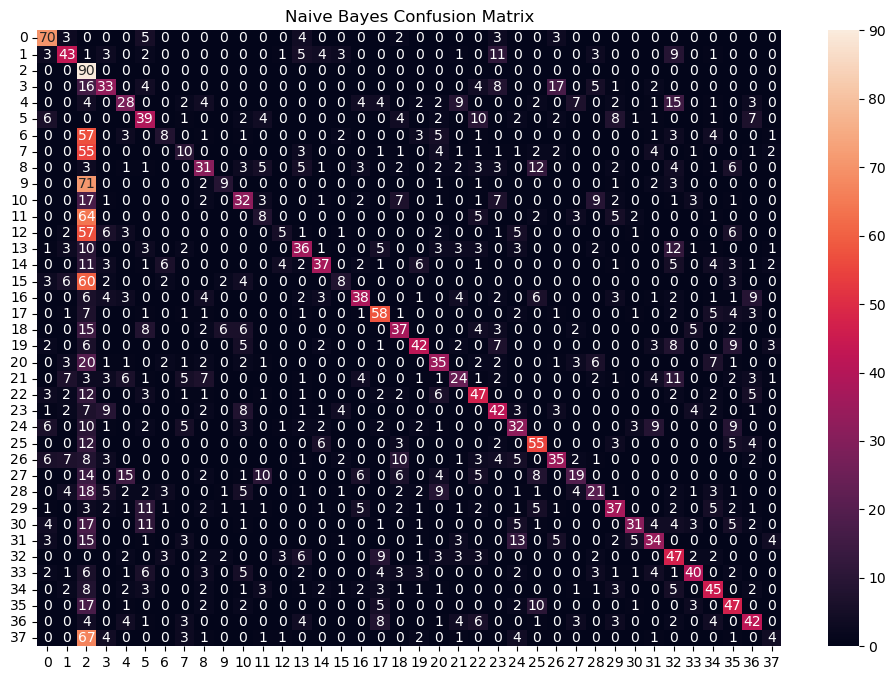

Naive Bayes Confusion Matrix Accuracy: 37.98%


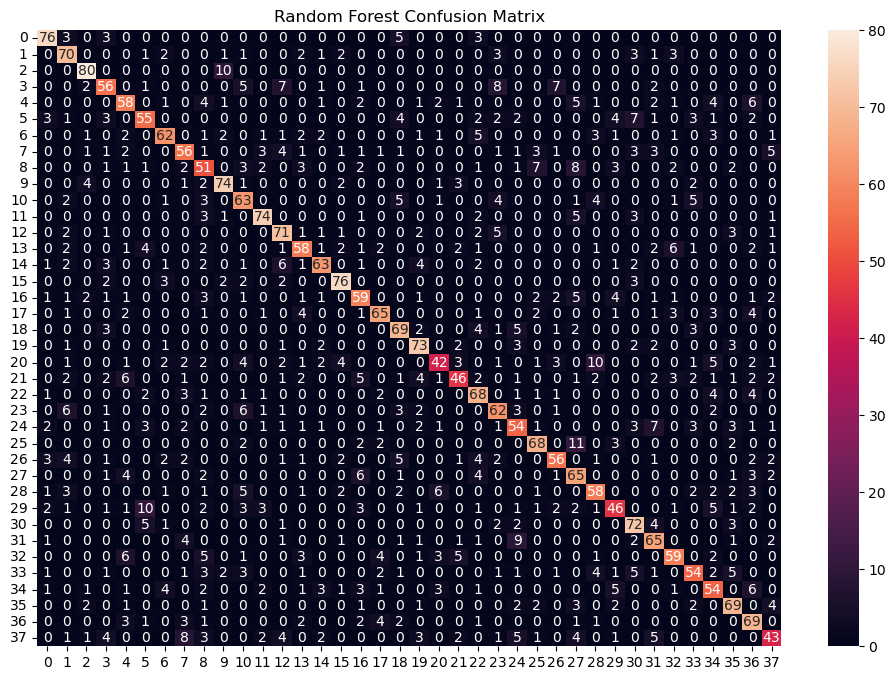

Random Forest Confusion Matrix Accuracy: 68.98%


In [36]:
def train_and_plot(model, X, y, title="Confusion Matrix"):
    model.fit(X, y)
    preds = model.predict(X)
    cf_matrix = confusion_matrix(y, preds)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cf_matrix, annot=True, fmt="d")
    plt.title(title)
    plt.show()
    print(f"{title} Accuracy: {accuracy_score(y, preds) * 100:.2f}%")
    return preds

svm_preds = train_and_plot(SVC(), X_resampled, y_resampled, "SVM Confusion Matrix")
nb_preds = train_and_plot(GaussianNB(), X_resampled, y_resampled, "Naive Bayes Confusion Matrix")
rf_preds = train_and_plot(RandomForestClassifier(random_state=42), X_resampled, y_resampled, "Random Forest Confusion Matrix")


---

## 6. Confusion Matrix Evaluation

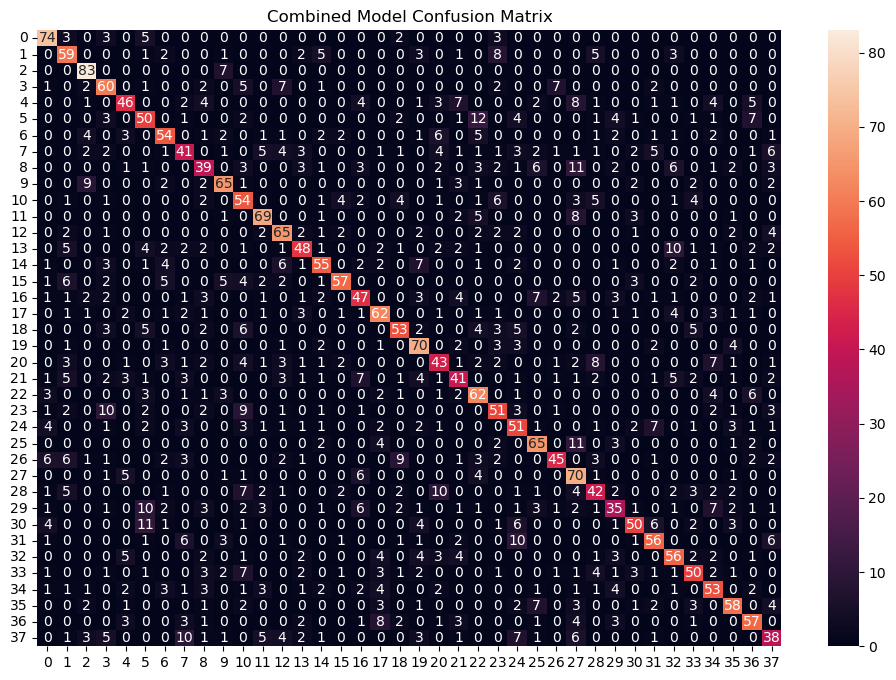

Combined Model Accuracy: 60.64%


In [37]:
final_preds = [mode([i, j, k]) for i, j, k in zip(svm_preds, nb_preds, rf_preds)]
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix(y_resampled, final_preds), annot=True, fmt="d")
plt.title("Combined Model Confusion Matrix")
plt.show()
print(f"Combined Model Accuracy: {accuracy_score(y_resampled, final_preds) * 100:.2f}%")



---

## 7. Prediction Function

In [38]:
symptoms = X.columns.values
symptom_index = {symptom: idx for idx, symptom in enumerate(symptoms)}

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)
nb_model = GaussianNB()
nb_model.fit(X_resampled, y_resampled)
svm_model = SVC()
svm_model.fit(X_resampled, y_resampled)

def predict_disease(input_symptoms, rf_model, nb_model, svm_model):
    input_symptoms = input_symptoms.split(",")
    input_data = [0] * len(symptom_index)
    
    for symptom in input_symptoms:
        symptom = symptom.strip()
        if symptom in symptom_index:
            input_data[symptom_index[symptom]] = 1

    input_df = pd.DataFrame([input_data], columns=symptoms)

    rf_pred = encoder.classes_[rf_model.predict(input_df)[0]]
    nb_pred = encoder.classes_[nb_model.predict(input_df)[0]]
    svm_pred = encoder.classes_[svm_model.predict(input_df)[0]]

    final_pred = mode([rf_pred, nb_pred, svm_pred])
    
    return {
        "Random Forest Prediction": rf_pred,
        "Naive Bayes Prediction": nb_pred,
        "SVM Prediction": svm_pred,
        "Final Prediction": final_pred
    }

# Example usage
print(predict_disease("skin_rash, fever, headache", rf_model, nb_model, svm_model))


{'Random Forest Prediction': 'Peptic ulcer disease', 'Naive Bayes Prediction': 'Impetigo', 'SVM Prediction': 'Peptic ulcer disease', 'Final Prediction': 'Peptic ulcer disease'}



---

## 8. Interactive Media

### Interactive Symptom Selection + Dynamic Real-Time Visualization

In [39]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Multi-select widget for symptoms

In [40]:
symptom_selector = widgets.SelectMultiple(
    options=list(symptom_index.keys()),  # symptom_index must already exist
    description='Symptoms:',
    rows=10,
    layout=widgets.Layout(width='50%')
)

# Dynamic output area
output = widgets.Output()

### Dynamic prediction visualization function

In [41]:
def update_visualization(change):
    with output:
        clear_output(wait=True)  # Clears old output for smooth updates
        
        selected_symptoms = ', '.join(symptom_selector.value)
        if not selected_symptoms:
            print("Please select at least one symptom to see predictions.")
            return

        # Get predictions
        results = predict_disease(selected_symptoms, rf_model, nb_model, svm_model) # pyright: ignore[reportUndefinedVariable]

        # Print textual results
        print("Selected Symptoms:", selected_symptoms)
        print("Predictions:")
        for key, value in results.items():
            print(f"  {key}: {value}")

        # Prepare dynamic bar chart
        labels = list(results.keys())
        final_pred = results["Final Prediction"]
        values = [1 if results[key] == final_pred else 0 for key in labels]
        colors = ['green' if v == 1 else 'orange' for v in values]

        fig = go.Figure(data=[go.Bar(
            x=labels,
            y=values,
            text=[f"{results[label]}" for label in labels],
            hoverinfo='text+y',
            marker_color=colors
        )])

        fig.update_layout(
            title=f"Prediction Agreement for: {selected_symptoms}",
            yaxis=dict(title='Match with Final Prediction', tickvals=[0,1], ticktext=['No','Yes']),
            xaxis=dict(title='Model'),
            showlegend=False,
            template='plotly_dark',
            height=450
        )
        fig.show()

### Set up interactive observer for multi-select

In [42]:
symptom_selector.observe(update_visualization, names='value')

### Display the interactive widgets

In [43]:
display(symptom_selector, output)

SelectMultiple(description='Symptoms:', layout=Layout(width='50%'), options=('fever', 'headache', 'nausea', 'v…

Output()


---

## 9. Conclusions

This project demonstrates the potential of machine learning for supporting clinical diagnostic prediction.

Future improvements may include:

- Larger real-world datasets  
- Additional performance metrics  
- Model interpretability tools  